# Etiquetage et annotation

Collecte de données automatisée de notre dossier d'images (116 images) pour le système de recommandation selon 5 critères dans un fichier 'etiquetage.json'.
- Orientation de l'images 
- Résolution de l'image
- ISO de l'image
- La catégorie : chien ou chat
- Animal dans la nature ou non ? proportion de vert dans l'image

In [2]:
from pandas import json_normalize
import pandas as pd
import json
import math
import matplotlib.pyplot as plot
import numpy as np

## EXIF des images

Dans un premier temps on récupère 3 données Exif dans un fichier JSON : nom de l'image, orientation de l'images, résolution de l'image et ISO de l'image

In [4]:
import os
import json
from PIL import Image
from PIL.ExifTags import TAGS

# Définir le dossier contenant les images
image_folder = "images/"
file = "etiquetage.json"

# Liste pour stocker les métadonnées
metadata_list = []

# Fonction pour déterminer l'orientation de l'image
def get_orientation(image):
    width, height = image.size
    if width > height:
        return "Paysage"
    elif width < height:
        return "Portrait"
    else:
        return "Carré"

# Parcourir tous les fichiers du dossier
for filename in os.listdir(image_folder):
    file_path = os.path.join(image_folder, filename)
    
    # Vérifier si c'est un fichier image
    try:
        with Image.open(file_path) as img:
            exif_data = img._getexif()  # Récupérer les métadonnées EXIF
            
            width, height = img.size  # Récupérer la résolution

            image_info = {
                "nom_image": filename,
                "orientation": get_orientation(img),
                "resolution": f"{width}x{height}",
                "iso": None
            }

            if exif_data:  
                for tag, value in exif_data.items():
                    tag_name = TAGS.get(tag, tag)  
                    
                    if tag_name == "ISOSpeedRatings":  
                        image_info["iso"] = value

            metadata_list.append(image_info)

    except Exception as e:
        print(f"Erreur avec {filename} : {e}")

# Sauvegarde des métadonnées dans un fichier JSON
with open(file, "w", encoding="utf-8") as json_file:
    json.dump(metadata_list, json_file, indent=4, ensure_ascii=False)

print(f"Métadonnées enregistrées dans {file}")


c:\Users\julie\OneDrive\Bureau\4ETI\Autres\env_msi\env_msi\Lib\site-packages\PIL\TiffImagePlugin.py:759: UserWarning: Metadata Warning, tag 33723 had too many entries: 2, expected 1
  warnings.warn(


Métadonnées enregistrées dans etiquetage.json


# Catégorie : chien ou chat

On utilise ....

In [32]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v2 import decode_predictions
from PIL import ImageOps

import numpy as np
import os
import json

# Charger le modèle MobileNetV2 pré-entrainé
model = MobileNetV2(weights='imagenet')

def prepare_image(image_path):
    # Charger l'image
    img = image.load_img(image_path)
    img = image.img_to_array(img)
    
    # Obtenir les dimensions de l'image
    height, width, _ = img.shape
    
    # Calculer les nouvelles dimensions tout en préservant le rapport d'aspect
    if height > width:
        new_height = 224
        new_width = int((width / height) * 224)
    else:
        new_width = 224
        new_height = int((height / width) * 224)
    
    # Redimensionner l'image en maintenant le rapport d'aspect
    img = image.array_to_img(img)
    img = img.resize((new_width, new_height))
    
    # Ajouter un fond pour que l'image fasse 224x224 (padding)
    padding = (224 - new_width) // 2, (224 - new_height) // 2
    img = ImageOps.expand(img, padding, (0, 0, 0))  # Noir comme fond
    
    # Convertir l'image en tableau numpy pour prétraitement
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Ajouter une dimension pour le batch
    img_array = preprocess_input(img_array)  # Prétraitement spécifique pour MobileNetV2
    return img_array

# Liste des catégories ImageNet correspondant à "chien" ou "chat"
dog_labels = ["dog", "puppy", "wolf", "coyote", "fox"]  # Mots-clés liés aux chiens
cat_labels = ["cat", "kitten", "tiger", "lynx", "leopard"]  # Mots-clés liés aux chats

def predict_image(image_path):
    # Préparer l'image
    preprocessed_image = prepare_image(image_path)
    
    # Faire la prédiction
    predictions = model.predict(preprocessed_image)
    
    # Décoder les prédictions (top 3 prédictions)
    decoded_predictions = decode_predictions(predictions, top=3)[0]
    
    # Vérifier si l'une des 3 premières classes correspond à un chat ou un chien
    for _, label, _ in decoded_predictions:
        if any(dog_word in label.lower() for dog_word in dog_labels):
            return 'Dog'
        elif any(cat_word in label.lower() for cat_word in cat_labels):
            return 'Cat'
    
    # Si aucune prédiction ne correspond, retourner "Unknown"
    return 'Unknown'


17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step
35363/35363 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
1: Samoyed (0.73)
2: Eskimo_dog (0.14)
3: dogsled (0.06)


In [33]:
# Charger les données existantes de etiquetage.json
if os.path.exists(file):
    with open(file, "r", encoding="utf-8") as f:
        metadata_list = json.load(f)
else:
    metadata_list = []

# Ajouter les prédictions à chaque image
for entry in metadata_list:
    # Chercher l'image correspondante dans le dossier
    image_name = entry.get("nom_image")
    if image_name:
        image_path = os.path.join(image_folder, image_name)
        
        if os.path.exists(image_path):  # Si le fichier image existe
            # Prédire si l'image est un chien ou un chat
            label = predict_image(image_path)
            
            # Ajouter la prédiction à l'élément de la liste
            entry['prediction'] = label

# Sauvegarder les résultats dans etiquetage.json
with open(file, "w", encoding="utf-8") as f:
    json.dump(metadata_list, f, indent=4, ensure_ascii=False)

print(f"Résultats mis à jour dans {file}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━

## Couleurs

On analyse ...

In [1]:
import json

file = "etiquetage.json"

# Charger le fichier JSON
with open(file, "r", encoding="utf-8") as json_file:
    data = json.load(json_file)

# Afficher le nombre d'éléments
print(f"Nombre d'éléments dans le fichier JSON : {len(data)}")

Nombre d'éléments dans le fichier JSON : 116


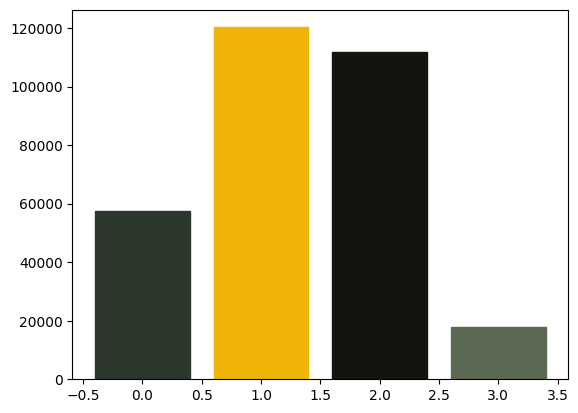

In [19]:
from PIL import Image
import numpy
import math
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

nmb_clusters = input("Donne moi le nombre de régions que tu veux")
nmb_clusters = int(nmb_clusters)
imgfile = Image.open("../images/flower.jpg")
numarray = numpy.array(imgfile.getdata(), numpy.uint8)
clusters = KMeans(n_clusters=nmb_clusters, n_init=2)
clusters.fit(numarray)
npbins = numpy.arange(0, nmb_clusters+1)
histogram = numpy.histogram(clusters.labels_, bins=npbins)
labels = numpy.unique(clusters.labels_)
barlist = plt.bar(labels, histogram[0])
for i in range(nmb_clusters):
    barlist[i].set_color(
        "#%02x%02x%02x"
        % (
            math.ceil(clusters.cluster_centers_[i][0]),
            math.ceil(clusters.cluster_centers_[i][1]),
            math.ceil(clusters.cluster_centers_[i][2]),
        )
    )
plt.show()